## Pre Processing

In [ ]:
import numpy as np 
import pandas as pd 
# import os
# import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pal = sns.color_palette()


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


df_train = pd.read_csv('/input/train.csv')
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


Total number of question pairs for training: 404290
Duplicate pairs: 36.92%
Total number of questions in the training data: 537933
Number of questions that appear multiple times: 111780



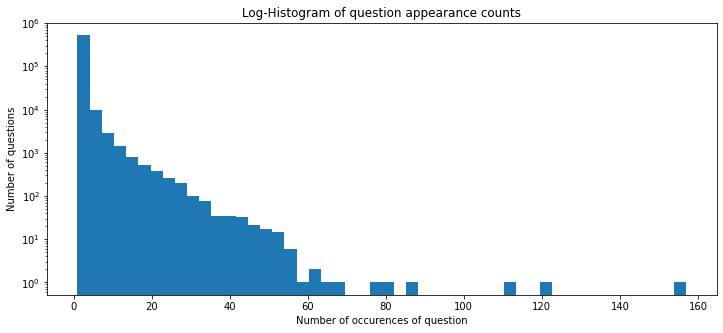

In [ ]:
print('Total number of question pairs for training: {}'.format(len(df_train)))
print('Duplicate pairs: {}%'.format(round(df_train['is_duplicate'].mean()*100, 2)))
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
print('Total number of questions in the training data: {}'.format(len(
    np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

In [ ]:
from sklearn.metrics import log_loss

p = df_train['is_duplicate'].mean() # Our predicted probability
print('Predicted score:', log_loss(df_train['is_duplicate'], np.zeros_like(df_train['is_duplicate']) + p))

df_test = pd.read_csv('/input/test.csv')
sub = pd.DataFrame({'test_id': df_test['test_id'], 'is_duplicate': p})
sub.to_csv('/input/naive_submission.csv', index=False)
sub.head()

Predicted score: 0.6585273839844354


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,test_id,is_duplicate
0,0,0.369198
1,1,0.369198
2,2,0.369198
3,3,0.369198
4,4,0.369198


In [ ]:
df_test = pd.read_csv('/input/test.csv')
df_test.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


mean-train 59.82 std-train 31.96 mean-test 60.07 std-test 31.63 max-train 1169.00 max-test 1176.00


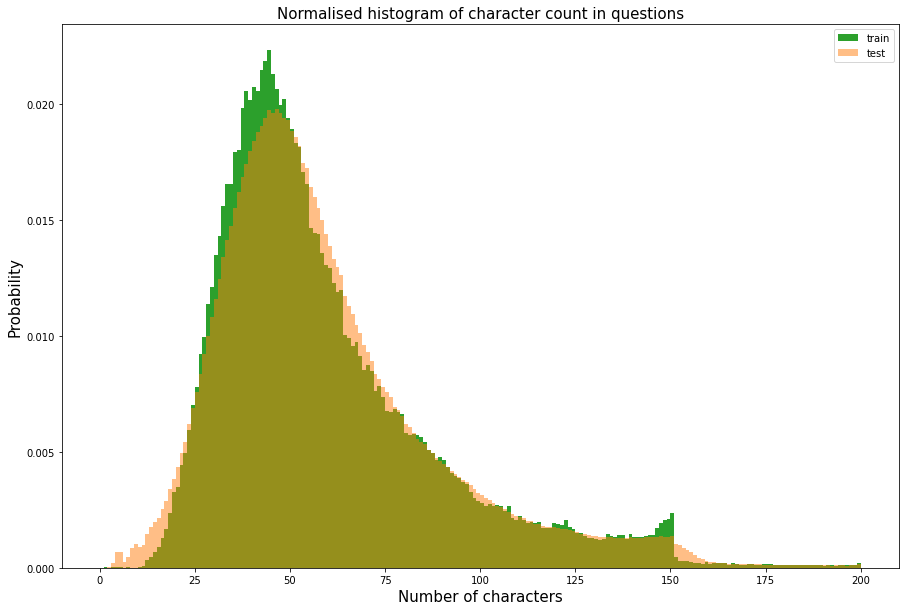

In [ ]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)

dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=200, range=[0, 200], color=pal[2], density=True, label='train')
plt.hist(dist_test, bins=200, range=[0, 200], color=pal[1], density=True, alpha=0.5, label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

mean-train 11.06 std-train 5.89 mean-test 11.02 std-test 5.84 max-train 237.00 max-test 238.00


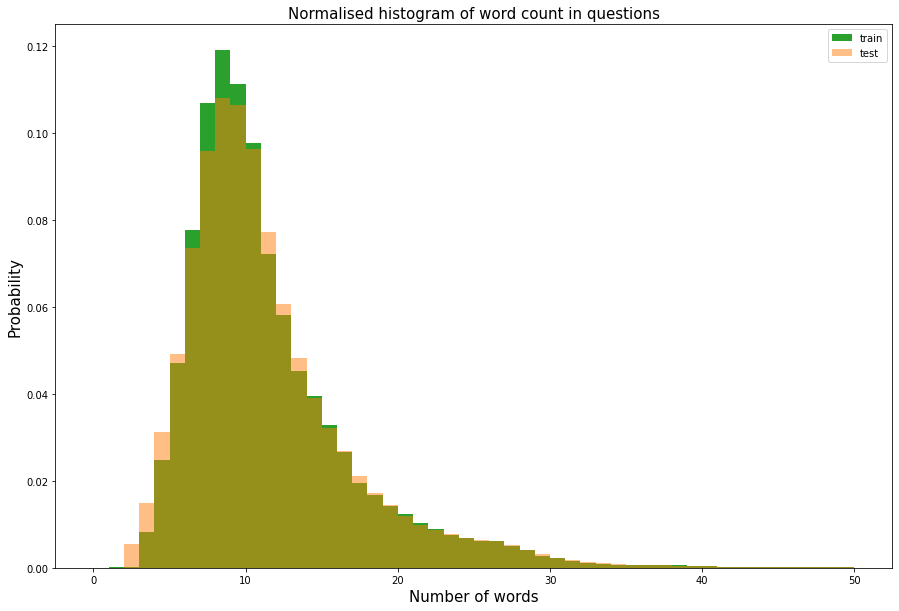

In [ ]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
dist_test = test_qs.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=50, range=[0, 50], color=pal[2], density=True, label='train')
plt.hist(dist_test, bins=50, range=[0, 50], color=pal[1], density=True, alpha=0.5, label='test')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

(-0.5, 1439.5, 1079.5, -0.5)

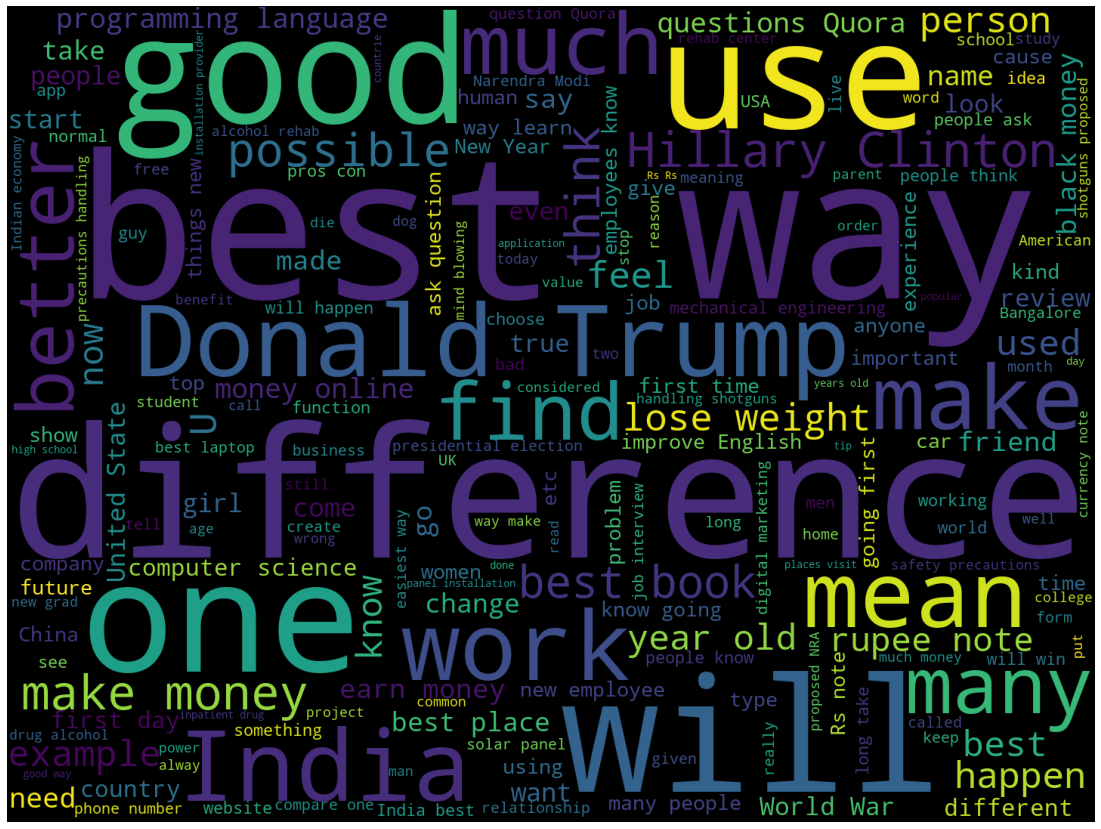

In [ ]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

In [ ]:
qmarks = np.mean(train_qs.apply(lambda x: '?' in x))
math = np.mean(train_qs.apply(lambda x: '[math]' in x))
fullstop = np.mean(train_qs.apply(lambda x: '.' in x))
capital_first = np.mean(train_qs.apply(lambda x: x[0].isupper()))
capitals = np.mean(train_qs.apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(train_qs.apply(lambda x: max([y.isdigit() for y in x])))

print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with [math] tags: {:.2f}%'.format(math * 100))
print('Questions with full stops: {:.2f}%'.format(fullstop * 100))
print('Questions with capitalised first letters: {:.2f}%'.format(capital_first * 100))
print('Questions with capital letters: {:.2f}%'.format(capitals * 100))
print('Questions with numbers: {:.2f}%'.format(numbers * 100))

Questions with question marks: 99.87%
Questions with [math] tags: 0.12%
Questions with full stops: 6.31%
Questions with capitalised first letters: 99.81%
Questions with capital letters: 99.95%
Questions with numbers: 11.83%


## XGBoost

In [ ]:
import nltk
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


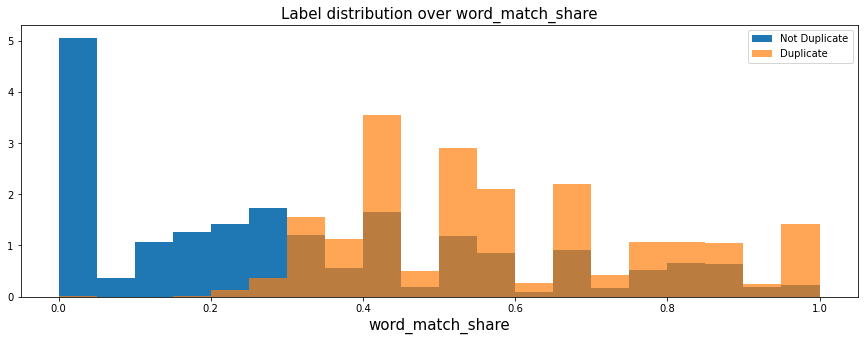

In [ ]:
nltk.download('stopwords')

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row[3]).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row[4]).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

plt.figure(figsize=(15, 5))
train_word_match = df_train.apply(word_match_share, axis=1, raw=True)
# train_word_match = word_match_share(df_train)
plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins=20, density=True, label='Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins=20, density=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)


def word_match_share_test(row):
    q1words = {}
    q2words = {}
    for word in str(row[1]).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row[2]).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2) + 1)/(len(q1words) + len(q2words) + 1)
    return R

In [ ]:
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [ ]:
print('Most common words and weights: \n')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

Most common words and weights: 

[('the', 2.5891040146646852e-06), ('what', 3.115623919267953e-06), ('is', 3.5861702928825277e-06), ('how', 4.366449945201053e-06), ('i', 4.4805878531263305e-06), ('a', 4.540645588989843e-06), ('to', 4.671434644293609e-06), ('in', 4.884625153865692e-06), ('of', 5.920242493132519e-06), ('do', 6.070908207867897e-06)]

Least common words and weights: 


[('シ', 9.998000399920016e-05),
 ('し?', 9.998000399920016e-05),
 ('19-year-old.', 9.998000399920016e-05),
 ('1-855-425-3768', 9.998000399920016e-05),
 ('confederates', 9.998000399920016e-05),
 ('asahi', 9.998000399920016e-05),
 ('fab', 9.998000399920016e-05),
 ('109?', 9.998000399920016e-05),
 ('samrudi', 9.998000399920016e-05),
 ('fulfill?', 9.998000399920016e-05)]

In [ ]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row[3]).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row[4]).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

def tfidf_word_match_share_test(row):
    q1words = {}
    q2words = {}
    for word in str(row[1]).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row[2]).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = (np.sum(shared_weights) + 1)/ (np.sum(total_weights) + 1)
    return R

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


Text(0.5, 0, 'word_match_share')

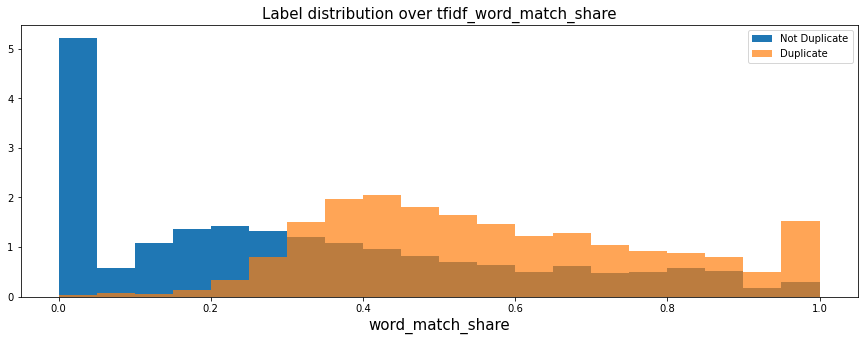

In [ ]:
plt.figure(figsize=(15, 5))
tfidf_train_word_match = df_train.apply(tfidf_word_match_share, axis=1, raw=True)
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 0].fillna(0), bins=20, density=True, label='Not Duplicate')
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 1].fillna(0), bins=20, density=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [ ]:
from sklearn.metrics import roc_auc_score
print('Original AUC:', roc_auc_score(df_train['is_duplicate'], train_word_match))
print('   TFIDF AUC:', roc_auc_score(df_train['is_duplicate'], tfidf_train_word_match.fillna(0)))

Original AUC: 0.7804327049353577
   TFIDF AUC: 0.7704802292218704


In [ ]:
# First we create our training and testing data
x_train = pd.DataFrame()
x_test = pd.DataFrame()
x_train['word_match'] = train_word_match
x_train['tfidf_word_match'] = tfidf_train_word_match
x_test['word_match'] = df_test.apply(word_match_share_test, axis=1, raw=True)
x_test['tfidf_word_match'] = df_test.apply(tfidf_word_match_share_test, axis=1, raw=True)

y_train = df_train['is_duplicate'].values

In [ ]:
pos_train = x_train[y_train == 1]
neg_train = x_train[y_train == 0]

# Now we oversample the negative class
# There is likely a much more elegant way to do this...
p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

0.19124366100096607


In [ ]:
# Finally, we split some of the data off for validation
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

In [ ]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.682892	valid-logloss:0.683124
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.602954	valid-logloss:0.602632
[20]	train-logloss:0.54455	valid-logloss:0.546043
[30]	train-logloss:0.503438	valid-logloss:0.504534
[40]	train-logloss:0.47254	valid-logloss:0.473365
[50]	train-logloss:0.448303	valid-logloss:0.45025
[60]	train-logloss:0.430186	valid-logloss:0.432094
[70]	train-logloss:0.416106	valid-logloss:0.418179
[80]	train-logloss:0.404828	valid-logloss:0.406955
[90]	train-logloss:0.396872	valid-logloss:0.398474
[100]	train-logloss:0.389924	valid-logloss:0.391695
[110]	train-logloss:0.384204	valid-logloss:0.38654
[120]	train-logloss:0.380296	valid-logloss:0.382033
[130]	train-logloss:0.377271	valid-logloss:0.37875
[140]	train-logloss:0.373967	valid-logloss:0.376189
[150]	train-logloss:0.371467	valid-logloss:0.374061
[160]	train-logloss:0.370377	vali

In [ ]:
d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = p_test
sub.to_csv('/input/simple_xgb.csv', index=False)

In [ ]:
import pandas as pd 
sub = pd.read_csv('/input/simple_xgb.csv')
sub.head(10)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,test_id,is_duplicate
0,0,0.043596
1,1,0.090708
2,2,0.079793
3,3,0.014900
4,4,0.214615
5,5,0.021979
6,6,0.090919
7,7,0.059596
8,8,0.090919
9,9,0.021979


## LSTM

In [ ]:
train_list1=list(df_train['question1'])
train_list2=list(df_train['question2'])
train_list=train_list1+train_list2

train_list

['What is the step by step guide to invest in share market in india?',
 'What is the story of Kohinoor (Koh-i-Noor) Diamond?',
 'How can I increase the speed of my internet connection while using a VPN?',
 'Why am I mentally very lonely? How can I solve it?',
 'Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?',
 'Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?',
 'Should I buy tiago?',
 'How can I be a good geologist?',
 'When do you use シ instead of し?',
 'Motorola (company): Can I hack my Charter Motorolla DCX3400?',
 'Method to find separation of slits using fresnel biprism?',
 'How do I read and find my YouTube comments?',
 'What can make Physics easy to learn?',
 'What was your first sexual experience like?',
 'What are the laws to change your status from a student visa to a green card in the US, how do they compare to the immigration laws in Canada?',
 'What would a Trump presidency mean for current international 

In [ ]:
import re
def removeNum(train_list):
  new_list = []
  for elem in train_list:
    elem = re.sub(r'[+-]?([0-9]*[.])?[0-9]+', ' ', str(elem))
    new_list.append(elem)

  return new_list

In [ ]:
vocab_size=20000
tokenizer=Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_list)

train_list1 = removeNum(train_list1)
train_list2 = removeNum(train_list2)
sequence1=tokenizer.texts_to_sequences(train_list1)
sequence2=tokenizer.texts_to_sequences(train_list2)

In [ ]:
#padding the sequences to a constant size
max_length=100
sequence1=pad_sequences(sequence1,maxlen=max_length,padding='post')
sequence2=pad_sequences(sequence2,maxlen=max_length,padding='post')

df_train['seq1']=list(sequence1)
df_train['seq2']=list(sequence2)

In [ ]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,seq1,seq2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[2, 3, 1, 1205, 57, 1205, 2534, 7, 566, 8, 746...","[2, 3, 1, 1205, 57, 1205, 2534, 7, 566, 8, 746..."
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[2, 3, 1, 549, 10, 13871, 13199, 5, 4474, 0, 0...","[2, 43, 176, 25, 1, 82, 229, 10999, 1, 13871, ..."
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[4, 13, 5, 211, 1, 431, 10, 17, 353, 1802, 194...","[4, 13, 353, 431, 24, 3271, 57, 1319, 213, 106..."
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[16, 72, 5, 2725, 304, 2710, 4, 13, 5, 633, 19...","[87, 1, 4087, 37, 222, 222, 3, 2414, 57, 0, 0,..."
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[23, 49, 6969, 8, 223, 1862, 2017, 10301, 12, ...","[23, 1917, 43, 1221, 8, 2017, 223, 0, 0, 0, 0,..."


In [ ]:
labels=np.asarray(df_train['is_duplicate'])

In [ ]:
#functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Embedding,LSTM,concatenate
from tensorflow.keras import Input

text_input1=Input(shape=(None,),dtype='int32')
embedding1=Embedding(vocab_size,64)(text_input1)
encoded_text1=LSTM(32)(embedding1)

text_input2=Input(shape=(None,),dtype='int32')
embedding2=Embedding(vocab_size,64)(text_input2)
encoded_text2=LSTM(32)(embedding2)

concatenated=concatenate([encoded_text1,encoded_text2],axis=-1)

output=Dense(64,activation='relu')(concatenated)
output=Dense(1,activation='sigmoid')(output)

In [ ]:
model=Model([text_input1,text_input2],output)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 64)     1280000     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 64)     1280000     ['input_2[0][0]']                
                                                                                              

In [ ]:
hist = model.fit([sequence1,sequence2],labels,epochs = 10,batch_size=128)

Epoch 1/10
3159/3159 [==============================] - 522s 164ms/step - loss: 0.6589 - accuracy: 0.6306
Epoch 2/10
3159/3159 [==============================] - 506s 160ms/step - loss: 0.6587 - accuracy: 0.6308
Epoch 3/10
3159/3159 [==============================] - 507s 160ms/step - loss: 0.6586 - accuracy: 0.6308
Epoch 4/10
3159/3159 [==============================] - 510s 161ms/step - loss: 0.6586 - accuracy: 0.6308
Epoch 5/10
3159/3159 [==============================] - 515s 163ms/step - loss: 0.6586 - accuracy: 0.6308
Epoch 6/10
3159/3159 [==============================] - 510s 161ms/step - loss: 0.6586 - accuracy: 0.6308
Epoch 7/10
3159/3159 [==============================] - 512s 162ms/step - loss: 0.6589 - accuracy: 0.6308
Epoch 8/10
3159/3159 [==============================] - 512s 162ms/step - loss: 0.6586 - accuracy: 0.6308
Epoch 9/10
3159/3159 [==============================] - 514s 163ms/step - loss: 0.6586 - accuracy: 0.6308
Epoch 10/10
3159/3159 [=======================

## TF-BERT

In [ ]:
df_train = df_train[df_train['question1'].apply(lambda x: isinstance(x, str))]
df_train = df_train[df_train['question2'].apply(lambda x: isinstance(x, str))]

In [ ]:
import string, six

re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()

def clean_text(s):
    try:
        return re.sub(r'[^A-Za-z0-9,?"\'. ]+', '', s).encode('utf-8').decode('utf-8').lower()
    except:
        return ""

def word_count_diff(row):
    try:
        q1words = len(list(filter(lambda x: x.lower() not in stops, tokenize(row['question1']))))
        q2words = len(list(filter(lambda x: x.lower() not in stops, tokenize(row['question2']))))
        return abs(q1words - q2words)
    except:
        return 50

In [ ]:
df_train['wms'] = df_train.apply(word_match_share, axis=1)
df_train['wcd'] = df_train.apply(word_count_diff, axis=1)

df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,seq1,seq2,wms,wcd
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[2, 3, 1, 1205, 57, 1205, 2534, 7, 566, 8, 746...","[2, 3, 1, 1205, 57, 1205, 2534, 7, 566, 8, 746...",0.727273,1
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[2, 3, 1, 549, 10, 13871, 13199, 5, 4474, 0, 0...","[2, 43, 176, 25, 1, 82, 229, 10999, 1, 13871, ...",0.307692,5
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[4, 13, 5, 211, 1, 431, 10, 17, 353, 1802, 194...","[4, 13, 353, 431, 24, 3271, 57, 1319, 213, 106...",0.363636,1
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[16, 72, 5, 2725, 304, 2710, 4, 13, 5, 633, 19...","[87, 1, 4087, 37, 222, 222, 3, 2414, 57, 0, 0,...",0.000000,14
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[23, 49, 6969, 8, 223, 1862, 2017, 10301, 12, ...","[23, 1917, 43, 1221, 8, 2017, 223, 0, 0, 0, 0,...",0.000000,7


In [ ]:
df_train.groupby(['is_duplicate']).agg({'wcd': np.mean}).reset_index()

,is_duplicate,wcd
0,0,3.022868
1,1,1.497035


In [ ]:
import tensorflow_hub as hub

hub_url = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
embed = hub.KerasLayer(hub_url, trainable=False)

In [ ]:
def euc_dist(x, y):
    return np.sqrt(np.dot((x-y), (x-y)))

X_train_q1 = df_train['question1'].tolist()
X_train_q2 = df_train['question2'].tolist()
X_wms = df_train['wms'].tolist()
X_wcd = df_train['wcd'].tolist()
y_train = (1-df_train['is_duplicate']).tolist()

In [ ]:
from sklearn.model_selection import train_test_split

X_train_q1, X_test_q1, X_train_q2, X_test_q2, X_wms_train, X_wms_test, X_wcd_train, X_wcd_test, y_train, y_test = train_test_split(X_train_q1, X_train_q2, X_wms, X_wcd, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [ ]:
X_wcd_train[:4]

[1, 1, 2, 2]

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [ ]:
input1 = Input(shape=(), dtype=tf.string)
input2 = Input(shape=(), dtype=tf.string)
input_wms = Input(shape=(1,), dtype=tf.float16)
input_wcd = Input(shape=(1,), dtype=tf.float16)

embed1 = embed(input1)
embed2 = embed(input2)

dist = Lambda(lambda x: K.sqrt(K.sum(K.square(x[0] - x[1]), axis=-1, keepdims=True)))([embed1,embed2])

concat = Concatenate(axis=1)([dist, input_wms, input_wcd])

hidden = Dense(9, activation="relu", kernel_regularizer=l2(1e-4))(concat)

out = Dense(1, activation="sigmoid", kernel_regularizer=l2(1e-4))(hidden)
model = Model(inputs=[input1, input2, input_wms, input_wcd], outputs=out)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       (None, 128)          124642688   ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['keras_layer[0][0]',      

In [ ]:
def step_decay(epoch):
    initial_lrate = 0.003
    drop = 0.5
    epochs_drop = 3
    lrate = initial_lrate * (drop**((1 + epoch)/epochs_drop))
    return lrate

lrate_scheduler = LearningRateScheduler(step_decay)
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model_chkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

model.fit(x=[np.array(X_train_q1), np.array(X_train_q2), np.array(X_wms_train), np.array(X_wcd_train)],
          y=np.array(y_train),
          batch_size=128,
          epochs=5,
          validation_data=([np.array(X_test_q1), np.array(X_test_q2), np.array(X_wms_test), np.array(X_wcd_test)], np.array(y_test)),
          callbacks=[lrate_scheduler, early_stop, model_chkpoint])

In [ ]:
df_test = pd.read_csv('/input/test.csv')

df_test['wms'] = df_test.apply(word_match_share_test, axis=1)
df_test['wcd'] = df_test.apply(word_count_diff, axis=1)

In [ ]:
df_test['question1'] = df_test['question1'].apply(lambda x: clean_text(x))
df_test['question2'] = df_test['question2'].apply(lambda x: clean_text(x))

df_test.head()

In [ ]:
X_test_q1 = df_test['question1'].tolist()
X_test_q2 = df_test['question2'].tolist()
X_test_wms = df_test['wms'].tolist()
X_test_wcd = df_test['wcd'].tolist()

In [ ]:
from tqdm import tqdm
preds = []
batch_size = 512
steps = len(X_test_q1) // batch_size + 1
for i in tqdm(range(0, steps)):
    X_test_q1_batch = np.array(X_test_q1[i*batch_size: i*batch_size+batch_size])
    X_test_q2_batch = np.array(X_test_q2[i*batch_size: i*batch_size+batch_size])
    X_test_wms_batch = np.array(X_test_wms[i*batch_size: i*batch_size+batch_size])
    X_test_wcd_batch = np.array(X_test_wcd[i*batch_size: i*batch_size+batch_size])
    preds.extend(model.predict([X_test_q1_batch, X_test_q2_batch, X_test_wms_batch, X_test_wcd_batch]))

In [ ]:
df_test.head()

In [ ]:
preds = [1 - x for x in preds]
df_test['is_duplicate'] = preds
# df_test = df_test.drop(['question1', 'question2', 'wms', 'wcd'], axis=1)
df_test.set_index('test_id').to_csv("/input/submission_Bert.csv")